In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import pandas as pd
import scipy

plt.close('all')

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd'

'/Users/nicholasbachand/Documents/Research/InteriorModeling'

In [32]:
# resultsTime = "20240311-111046"
resultsTime = "20240405-165712"
outputs = pd.read_csv(f'{home_dir}/resultsMC/outputs_{resultsTime}.csv', header=[0, 1], index_col=0)
inputs = pd.read_csv(f'{home_dir}/resultsMC/inputs_{resultsTime}.csv', index_col=0)
display(inputs, outputs)


,floorTempAdjustment,hInterior,hExterior,alphaRoof,material_type,windSpeed,wallRoughness
0,-4.151563,2.001253,11.217357,0.843408,Medium,3.322042,1.864905
1,-4.078241,2.258220,11.402305,0.867548,Light,5.932907,1.127771
2,-4.522329,1.339542,10.130242,0.876498,Medium,3.663076,1.555270
3,-4.766832,2.937751,1.718429,0.664084,Light,0.265560,1.787955
4,-4.753797,2.846740,3.970162,0.882422,Light,1.081512,1.503829
5,-4.235076,1.875007,6.326883,0.726592,Medium,2.195727,1.378699
6,-4.878293,2.589041,9.379598,0.759569,Heavy,2.515776,2.093179
7,-4.948857,2.416590,9.305954,0.833562,Medium,2.462427,2.058289


day_1                                                          \
       hVent dVent ceilingMinusFloor outMinusFloor intWallMinusFloor   
0                                                                      
1  17.393056   0.0          2.666453      1.658226          1.318481   
2        NaN   NaN               NaN           NaN               NaN   
3  17.145833   0.0          3.476542      1.756839          1.348049   
4  16.408333   0.0          3.565997      1.728423          1.367777   
5        NaN   NaN               NaN           NaN               NaN   
6        NaN   NaN               NaN           NaN               NaN   
7        NaN   NaN               NaN           NaN               NaN   

                     
  extWallMinusFloor  
0                    
1          2.593603  
2               NaN  
3          2.351748  
4          2.163621  
5               NaN  
6               NaN  
7               NaN

In [33]:
outputs.columns.get_level_values(0).unique().values

array(['day_1'], dtype=object)

In [34]:
dfFull = pd.DataFrame()
days = outputs.columns.get_level_values(0).unique().values
for day in days:
    df = pd.concat([inputs, outputs[day][["ceilingMinusFloor", "outMinusFloor", "intWallMinusFloor", "extWallMinusFloor"]]], axis=1)
    df["day"] = int(day[4:])
    dfFull = pd.concat([dfFull, df], axis = "index")

dfFull = dfFull.reset_index(drop=True)
dfFull

,floorTempAdjustment,hInterior,hExterior,alphaRoof,material_type,windSpeed,wallRoughness,ceilingMinusFloor,outMinusFloor,intWallMinusFloor,extWallMinusFloor,day
0,-4.151563,2.001253,11.217357,0.843408,Medium,3.322042,1.864905,NaN,NaN,NaN,NaN,1
1,-4.078241,2.258220,11.402305,0.867548,Light,5.932907,1.127771,2.666453,1.658226,1.318481,2.593603,1
2,-4.522329,1.339542,10.130242,0.876498,Medium,3.663076,1.555270,NaN,NaN,NaN,NaN,1
3,-4.766832,2.937751,1.718429,0.664084,Light,0.265560,1.787955,3.476542,1.756839,1.348049,2.351748,1
4,-4.753797,2.846740,3.970162,0.882422,Light,1.081512,1.503829,3.565997,1.728423,1.367777,2.163621,1
5,-4.235076,1.875007,6.326883,0.726592,Medium,2.195727,1.378699,NaN,NaN,NaN,NaN,1
6,-4.878293,2.589041,9.379598,0.759569,Heavy,2.515776,2.093179,NaN,NaN,NaN,NaN,1
7,-4.948857,2.416590,9.305954,0.833562,Medium,2.462427,2.058289,NaN,NaN,NaN,NaN,1


In [35]:
dropCondition = dfFull["ceilingMinusFloor"] > 10
dfFull = dfFull[~dropCondition]

In [36]:
def ventRi(delT, V, H = 3):
    g = 10
    Tref = 288.15
    return g * delT / Tref * H / V**2

dfFull.loc[:, "Ri"] = ventRi(dfFull["ceilingMinusFloor"], dfFull["windSpeed"])
dfFull.loc[:, "logRi"] = np.log(dfFull["Ri"])
dfFull

,floorTempAdjustment,hInterior,hExterior,alphaRoof,material_type,windSpeed,wallRoughness,ceilingMinusFloor,outMinusFloor,intWallMinusFloor,extWallMinusFloor,day,Ri,logRi
0,-4.151563,2.001253,11.217357,0.843408,Medium,3.322042,1.864905,NaN,NaN,NaN,NaN,1,NaN,NaN
1,-4.078241,2.258220,11.402305,0.867548,Light,5.932907,1.127771,2.666453,1.658226,1.318481,2.593603,1,0.007887,-4.842563
2,-4.522329,1.339542,10.130242,0.876498,Medium,3.663076,1.555270,NaN,NaN,NaN,NaN,1,NaN,NaN
3,-4.766832,2.937751,1.718429,0.664084,Light,0.265560,1.787955,3.476542,1.756839,1.348049,2.351748,1,5.132453,1.635584
4,-4.753797,2.846740,3.970162,0.882422,Light,1.081512,1.503829,3.565997,1.728423,1.367777,2.163621,1,0.317410,-1.147561
5,-4.235076,1.875007,6.326883,0.726592,Medium,2.195727,1.378699,NaN,NaN,NaN,NaN,1,NaN,NaN
6,-4.878293,2.589041,9.379598,0.759569,Heavy,2.515776,2.093179,NaN,NaN,NaN,NaN,1,NaN,NaN
7,-4.948857,2.416590,9.305954,0.833562,Medium,2.462427,2.058289,NaN,NaN,NaN,NaN,1,NaN,NaN


In [37]:
qois = ["ceilingMinusFloor", "outMinusFloor", "intWallMinusFloor", "extWallMinusFloor"]
fig = px.histogram(
    dfFull,
    x = qois,
    marginal="box", # or violin, rug
    barmode = "group"
    )
fig.show()

fig = px.line(dfFull, y = qois)
fig.show()


In [38]:
fig = px.scatter(dfFull, x="floorTempAdjustment", y=qois, facet_col="material_type", trendline="ols")
fig.show()
fig = px.scatter(dfFull, x="hInterior", y=qois, facet_col="material_type", trendline="ols")
fig.show()
fig = px.scatter(dfFull, x="alphaRoof", y=qois, facet_col="material_type", trendline="ols")
fig.show()
fig = px.scatter(dfFull, x="day", y=qois, facet_col="material_type", trendline="ols")
fig.show()
fig = px.scatter(dfFull, x="windSpeed", y=qois, facet_col="material_type", trendline="ols")
fig.show()
fig = px.scatter(dfFull, x="wallRoughness", y=qois, facet_col="material_type", trendline="ols")
fig.show()
fig = px.scatter(dfFull, x="hExterior", y=qois, facet_col="material_type", trendline="ols")
fig.show()
fig = px.scatter(dfFull, x="logRi", y=qois, facet_col="material_type", trendline="ols")
fig.show()

In [39]:
fig = px.scatter(dfFull, x="windSpeed", y="logRi", symbol="material_type")
fig.show()
fig = px.scatter(dfFull.loc[dfFull["windSpeed"] >= 2], x="windSpeed", y="Ri", symbol="material_type")
fig.show()

In [40]:
fig = px.scatter_3d(dfFull, x="outMinusFloor", y="ceilingMinusFloor", z="extWallMinusFloor", color="intWallMinusFloor", symbol="material_type", size = "windSpeed")
fig.show()

# fig = px.scatter(dfFull, x="outMinusFloor", y="ceilingMinusFloor", color="intWallMinusFloor", symbol="material_type",  size = "windSpeed")
# fig.show()
# fig = px.scatter(dfFull, x="outMinusFloor", y="extWallMinusFloor", color="intWallMinusFloor", symbol="material_type",  size = "windSpeed")
# fig.show()
# fig = px.scatter(dfFull, x="ceilingMinusFloor", y="extWallMinusFloor", color="intWallMinusFloor", symbol="material_type",  size = "windSpeed")
# fig.show()

In [43]:
qoiX = dfFull.dropna()[qois]
U, S, V = np.linalg.svd(qoiX)
S

array([7.91600828, 0.66062686, 0.04325304])

In [44]:
qoiX @ V[0:2,:].T

,0,1
1,4.245974,0.544516
3,4.743253,-0.145670
4,4.704938,-0.344543


In [45]:
fig = px.scatter_3d(qoiX @ V.T, x=0, y=1, z=2, color=3)
fig.show()

fig = px.scatter(qoiX @ V[0:2,:].T, x=0, y=1, color=dfFull["windSpeed"], symbol=dfFull["material_type"])
fig.show()

fig = px.scatter(qoiX @ V[2:,:].T, x=0, y=1, color=dfFull["windSpeed"], symbol=dfFull["material_type"])
fig.show()

ValueError: All arguments should have the same length. The length of argument `color` is 8, whereas the length of  previously-processed arguments ['0', '1'] is 3

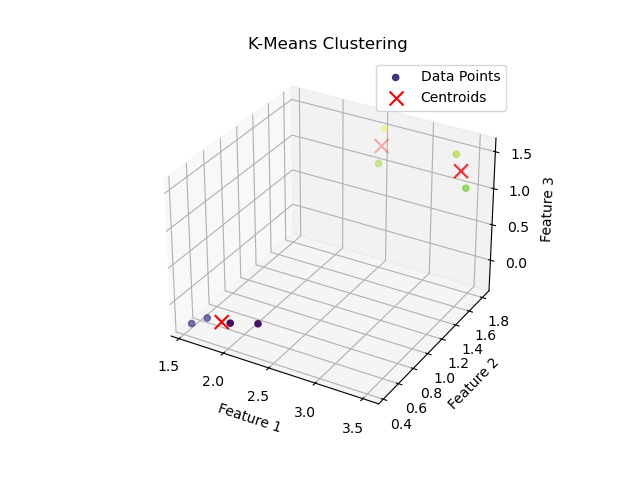

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming X contains your 4-dimensional data
# X = [[feature1_1, feature2_1, feature3_1, feature4_1],
#      [feature1_2, feature2_2, feature3_2, feature4_2],
#      ...
#      [feature1_n, feature2_n, feature3_n, feature4_n]]

# Step 2: Choose the number of clusters (k)
k = 3

# Step 3: Apply K-Means Algorithm
kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')

# Step 4: Fit the model
kmeans.fit(qoiX)

# Step 5: Cluster Assignment
labels = kmeans.labels_

# Step 6: Interpret Results
centroids = kmeans.cluster_centers_

# Analyze the clusters and visualize the results as needed


# Plotting the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data points
ax.scatter(qoiX.iloc[:, 0], qoiX.iloc[:, 1], qoiX.iloc[:, 2], c=qoiX.iloc[:, 3], cmap='viridis', label='Data Points')

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='x', s=100, c='red', label='Centroids')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('K-Means Clustering')

plt.legend()
plt.show()
